# Station Air Pollution Estimation

For each station, find a good model to predict the individual pollutants.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
metrics = [root_mean_squared_error, r2_score, mean_absolute_error]

from utils import *

datasets_folder = './datasets'
verbosity=0

2025-03-22 21:15:10.787409: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-22 21:15:10.885109: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-22 21:15:10.980622: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742703311.065186  150930 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742703311.088334  150930 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742703311.262314  150930 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## Data Import

We will only focus on the station with the most agents, Porta San Felice.

In [2]:
san_felice_pollution_dict = read_and_preprocess_dataset(datasets_folder, 'pollution', resample=False, v=verbosity)[1]
san_felice_traffic_df = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity)[1]
weather_df = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

In [3]:
san_felice_data = prepare_station_data_for_training(san_felice_pollution_dict, san_felice_traffic_df, weather_df
                                                    # , encoding_method='radial_months_days-sin-cos_hours'
                                                    , encoding_method='radial_months-sin-cos_days_hours'
                                                    )
print(*list(san_felice_data.keys()), sep=', ')
# list(san_felice_data.values())[0].head(5)

C6H6, CO, NO, NO2, NOX, PM10, PM2.5


## Models

For each station we develop a model to describe the air pollution. Given that each station collects different data, and sometimes with different intensities, we decided to treat each station indepentendtely.

Air polution follows this criteria:
- for each pollutant a certain limit is defined (like 25 µg/m³ for PM2.5)
- for each pollutant $ AQI = \frac{Concentration}{Limit} \times 100 $
- take the maximum value across all the IQAs 

The overage value is then matched on the following table:

| **AQI**         | **CONDITIONS** |
| --------------- | -------------- |
| <30             | EXCELLENT      |
| From 34 to 66   | GOOD           |
| From 67 to 99   | FAIR           |
| From 99 to 150  | POOR           |
| >150            | VERY POOR      |

We are going to model each agent to predict its hour value and then use all of the predictions to compute the overall Air Quality Index and compare it with the one got from the readings.

In [4]:
pollutant_limits = {
    'PM2.5': 25,    # µg/m³
    'PM10': 50,     # µg/m³
    'CO': 10,       # mg/m³
    'O3': 180,      # µg/m³
    'NO': None,     # µg/m³
    'NO2': 200,     # µg/m³
    'NOX': None,    # µg/m³
    'C6H6': None    # µg/m³
}

In [5]:
train_split_date = datetime(2023,12,31,23)
target = 'Agent_value'

From the first notebook:
- Agent C6H6: 3675 *(0.0699%)* missing Values
- Agent CO: 821 *(0.0156%)* missing Values
- Agent NO: 1056 *(0.0201%)* missing Values
- Agent NO2: 1056 *(0.0201%)* missing Values
- Agent NOX: 940 *(0.0179%)* missing Values
- Agent PM10: 57 *(0.0260%)* missing Values
- Agent PM2.5: 54 *(0.0246%)* missing Values

We focus on CO beacuse it has the least missing values.

### **Estimations**

In [8]:
co_x_train, co_y_train, co_x_test, co_y_test = create_train_test(san_felice_data['C6H6'], train_split_date, y=target)

#### **Random Forest Regressor**

In [9]:
from sklearn.ensemble import RandomForestRegressor

co_rand_forest = RandomForestRegressor(n_estimators=100,max_depth=10,random_state=42)

co_rand_forest.fit(co_x_train, co_y_train[target])

RandomForestRegressor(max_depth=10, random_state=42)

In [10]:
co_y_pred_rf = co_rand_forest.predict(co_x_test)
co_y_pred_df_rf = pd.DataFrame(co_y_pred_rf, index=co_y_test.index) # serve perchè le predizioni partono da zero, ma y_test ha ancora gli indici giusti

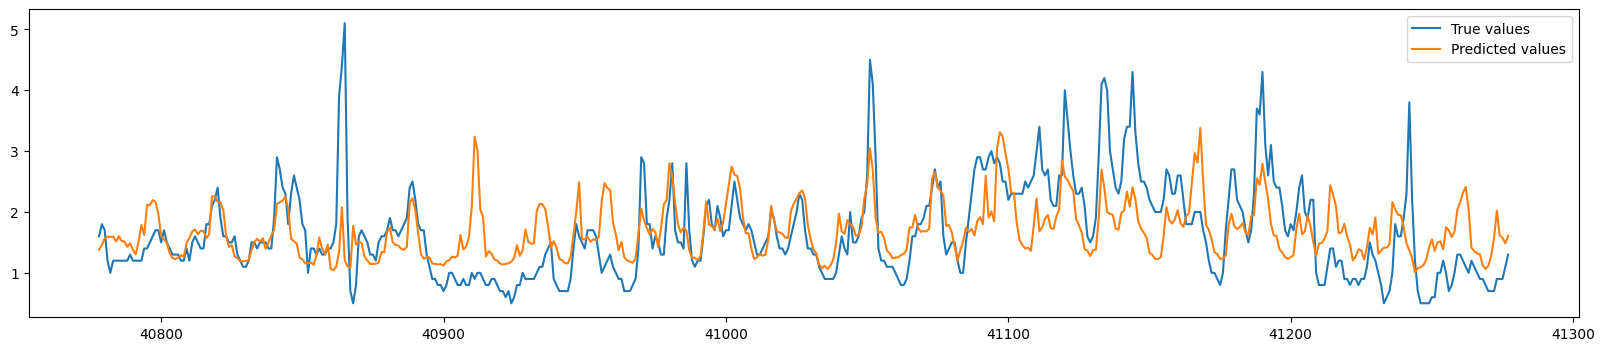

In [13]:
plt.figure(figsize=(20,4))
plt.plot(co_y_test.iloc[:500], label='True values')
plt.plot(co_y_pred_df_rf.iloc[:500], label='Predicted values')
plt.legend()
plt.show()

#### **LSTM**

In [117]:
def build_model(in_shape,
                optimizer='adam',
                loss='mse'
                ):
    model = Sequential([
        LSTM(128, return_sequences=False, input_shape=(in_shape[1], in_shape[2])),
        # Dropout(0.2),
        # LSTM(50, return_sequences=False),
        # Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss=loss)

    return model

In [118]:
def create_sequences(x_df, y_df, time_steps=10):
    X, y = [], []
    for i in range(len(x_df) - time_steps):
        X.append(x_df.iloc[i:i+time_steps].values)
        y.append(y_df.iloc[i+time_steps])
    return np.array(X), np.array(y)

time_steps = 5  # Use past 30 hours for prediction
feature_cols = co_x_train.columns.tolist()

co_x_train_seq, co_y_train_seq = create_sequences(co_x_train, co_y_train, time_steps)
co_x_test_lstm, co_y_test_lstm = pd.concat([co_x_train.iloc[-time_steps:], co_x_test]), pd.concat([co_y_train.iloc[-time_steps:], co_y_test]),
co_x_test_seq, co_y_test_seq = create_sequences(co_x_test_lstm, co_y_test_lstm, time_steps)

In [119]:
tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

[]


In [120]:
co_lstm = build_model(co_x_train_seq.shape,  optimizer=Adam(learning_rate=1e-2), loss='mean_absolute_error')
co_lstm.fit(
    co_x_train_seq,
    co_y_train_seq,
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.3139
Epoch 2/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2660
Epoch 3/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2545
Epoch 4/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2524
Epoch 5/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2445
Epoch 6/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2429
Epoch 7/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2418
Epoch 8/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.2365
Epoch 9/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.2333
Epoch 10/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.2303


In [121]:
co_y_pred_lstm = co_lstm.predict(co_x_test_seq)
co_y_pred_df_lstm = pd.DataFrame(co_y_pred_lstm, index=co_y_test_lstm.index[time_steps:])

255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


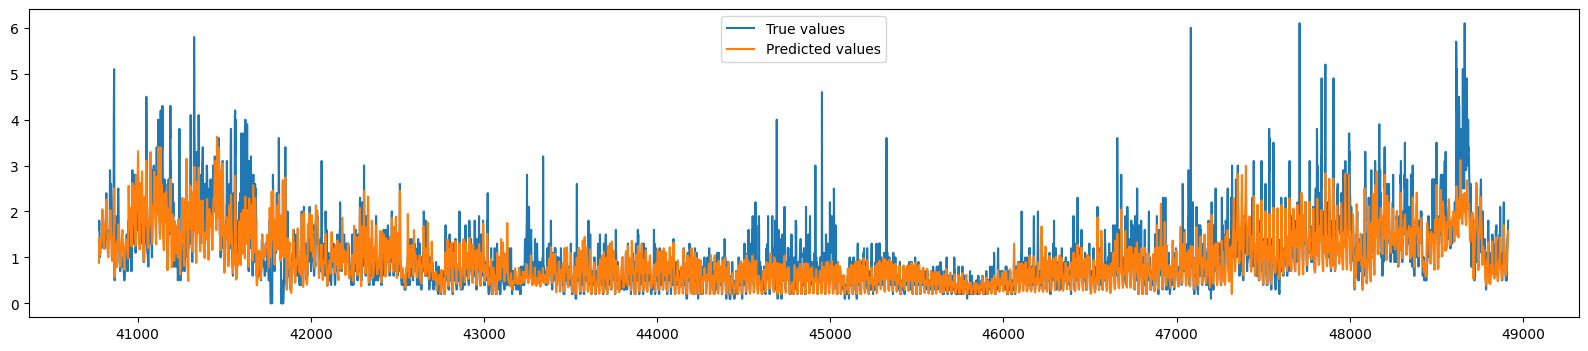

root_mean_squared_error: 0.4198601085123304
r2_score: 0.6439013322082248
mean_absolute_error: 0.2614264726613156


In [122]:
plt.figure(figsize=(20,4))
plt.plot(co_y_test_lstm.iloc[time_steps:], label='True values')
plt.plot(co_y_pred_df_lstm, label='Predicted values')
plt.legend()
plt.show()

for m in metrics:
    score = m(co_y_test_lstm.iloc[time_steps:],co_y_pred_df_lstm)
    print(f'{m.__name__}: {score}')

#### **Feed Forward Neural Network**

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [22]:
def build_ffnn(in_shape,
               optimizer='adam',
               loss='mse'):
    model = Sequential([
        Dense(1024, activation='relu', input_shape=(in_shape,)),
        Dropout(0.2),
        Dense(512, activation='relu'), 
        Dropout(0.2),
        Dense(256, activation='relu'),  
        Dropout(0.2),
        Dense(128, activation='relu'),  
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss=loss)

    return model

in_shape = len(co_x_train.columns)


In [23]:
co_ffnn = build_ffnn(in_shape, optimizer=Adam(learning_rate=1e-2),loss='mean_absolute_error')
# print(co_ffnn.summary()) 
co_ffnn.fit(co_x_train, co_y_train, epochs=10, batch_size=32)

Epoch 1/10


/home/davide/Desktop/AI/AIII/project/AII-project/aiii-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1275/1275 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.4137
Epoch 2/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.3120
Epoch 3/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.3082
Epoch 4/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.3059
Epoch 5/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.3082
Epoch 6/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.2980
Epoch 7/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.2952
Epoch 8/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.2962
Epoch 9/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.3013
Epoch 10/10
1275/1275 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.2975


In [28]:
co_y_pred_ffnn = co_ffnn.predict(co_x_test)
co_y_pred_df_ffnn = pd.DataFrame(co_y_pred_ffnn, index=co_y_test.index) # serve perchè le predizioni partono da zero, ma y_test ha ancora gli indici giusti

255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


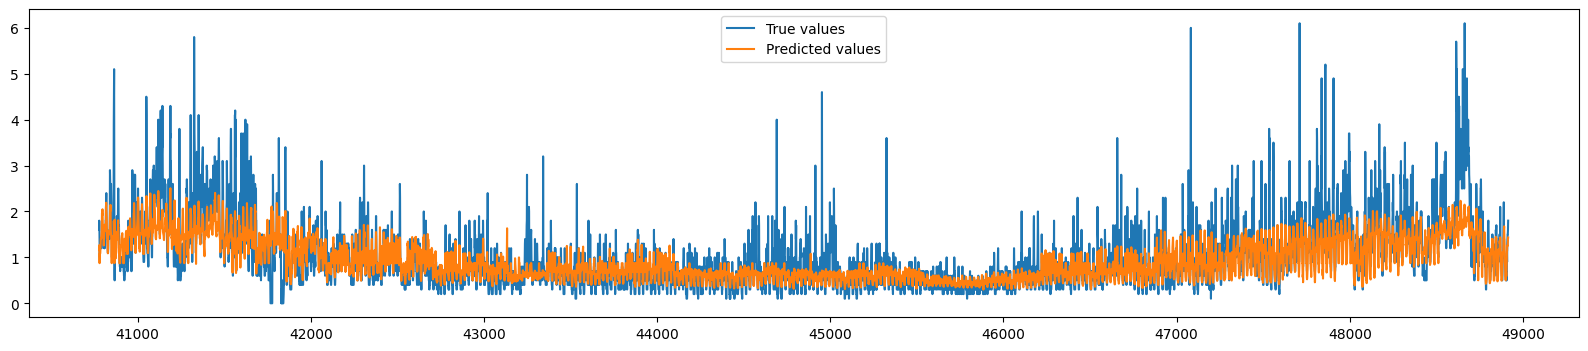

root_mean_squared_error: 0.4624029881985885
r2_score: 0.5680809238678473
mean_absolute_error: 0.2879647345445923


In [29]:
plt.figure(figsize=(20,4))
plt.plot(co_y_test, label='True values')
plt.plot(co_y_pred_df_ffnn, label='Predicted values')
plt.legend()
plt.show()
for m in metrics:
    score = m(co_y_test,co_y_pred_df_ffnn)
    print(f'{m.__name__}: {score}')

#### **XGBoost**

In [30]:
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=100,
    # max_depth=20
    )
model.fit(co_x_train, co_y_train)

co_y_pred_xgb = model.predict(co_x_test)
co_y_pred_df_xgb = pd.DataFrame(co_y_pred_xgb, index=co_y_test.index)

### Comparison

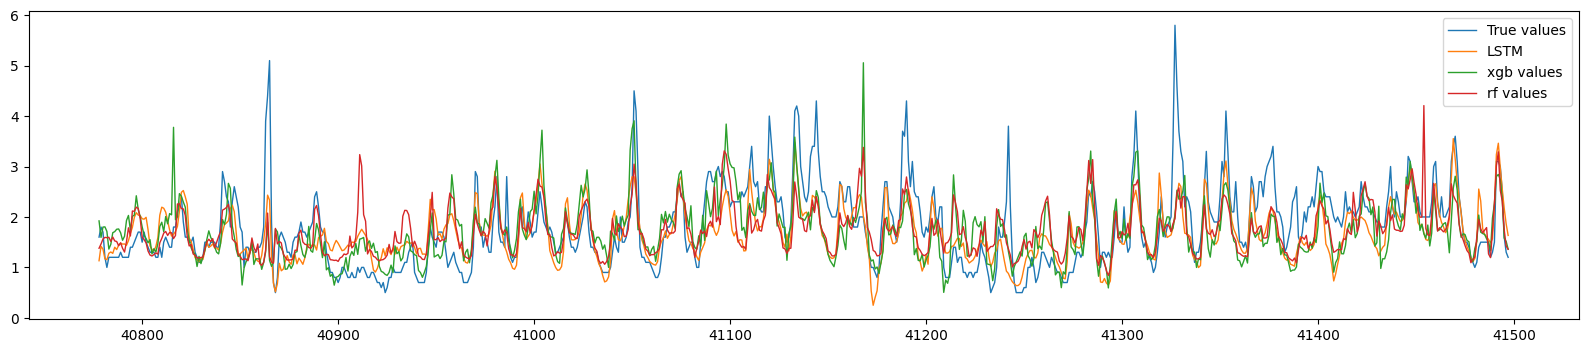

root_mean_squared_error:
 - LSTM: 0.41704967092717865
 - FFNN: 0.4624029881985885
 - XGB: 0.4627208124527462
 - RF: 0.4605332552349492
r2_score:
 - LSTM: 0.6486526459512245
 - FFNN: 0.5680809238678473
 - XGB: 0.5674869764313246
 - RF: 0.5715668036644324
mean_absolute_error:
 - LSTM: 0.25898030202973604
 - FFNN: 0.2879647345445923
 - XGB: 0.28880039346165737
 - RF: 0.2852784094186737


In [82]:
samples = 30*24
offset =  31 * 0

plt.figure(figsize=(20,4))
plt.plot(co_y_test.iloc[offset:samples+offset], label='True values', linewidth=1)
plt.plot(co_y_pred_df_lstm.iloc[offset:samples+offset], label='LSTM', linewidth=1)
# plt.plot(co_y_pred_df_lstm2.iloc[offset:samples+offset], label='LSTM 2', linewidth=1)
# plt.plot(co_y_pred_df_ffnn.iloc[offset:samples+offset], label='ffnn values', linewidth=1)
plt.plot(co_y_pred_df_xgb.iloc[offset:samples+offset], label='xgb values', linewidth=1)
plt.plot(co_y_pred_df_rf.iloc[offset:samples+offset], label='rf values', linewidth=1)
# plt.xlim(co_y_test.index[0],co_y_test.index[-1])
plt.legend()
plt.show()

for m in metrics:
    score_lstm = m(co_y_test_lstm.iloc[time_steps:],co_y_pred_df_lstm)
    # score_lstm2 = m(co_y_test.iloc[time_steps:],co_y_pred_df_lstm2)
    score_ffnn = m(co_y_test,co_y_pred_df_ffnn)
    score_xgb = m(co_y_test,co_y_pred_df_xgb)
    score_rf = m(co_y_test,co_y_pred_df_rf)
    print(f'{m.__name__}:')
    print(f' - LSTM: {score_lstm}')
    # print(f' - LSTM: {score_lstm2}')
    print(f' - FFNN: {score_ffnn}')
    print(f' - XGB: {score_xgb}')
    print(f' - RF: {score_rf}')

root_mean_squared_error:
 - LSTM: 16.78633500788745
 - FFNN: 19.03708320763799
 - XGB: 17.417460042310967
 - RF: 17.503213839929646
r2_score:
 - LSTM: 0.4733509604003272
 - FFNN: 0.32231664786655956
 - XGB: 0.4327223850036688
 - RF: 0.4271227208748478
mean_absolute_error:
 - LSTM: 9.77946031315951
 - FFNN: 10.238628302283821
 - XGB: 10.025702926055418
 - RF: 9.510767515911347

['Traffic_value', 'TAVG', 'PREC', 'RHAVG', 'RAD', 'W_SCAL_INT', 'W_VEC_DIR', 'W_VEC_INT', 'LEAFW', 'ET0']


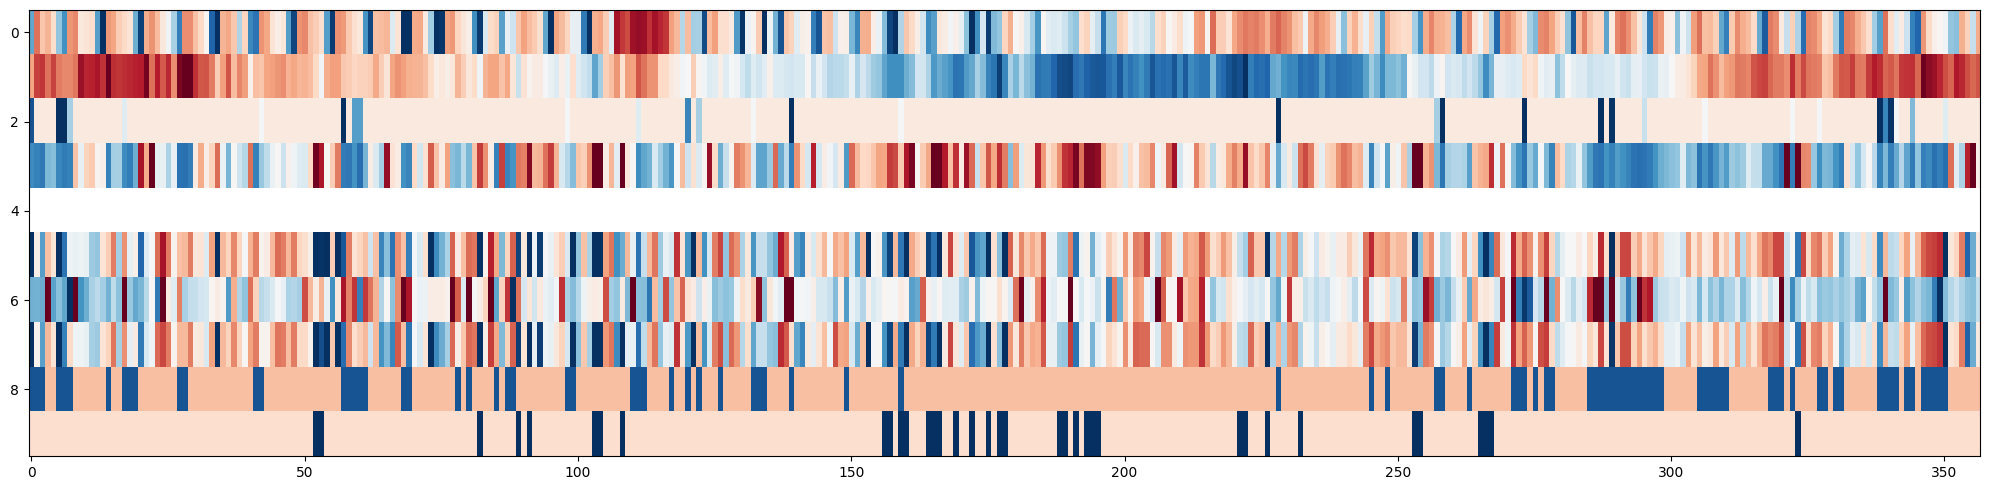

In [102]:
cols=co_x_test.columns[:10]
hpcsv = co_x_test[cols].copy()
hpcsv = (hpcsv - hpcsv.mean()) / hpcsv.std()
plot_dataframe(hpcsv[offset:samples+offset])
print([c for c in cols])

In [77]:
co_y_pred_lstm_train = co_lstm.predict(co_x_train_seq)
co_y_pred_df_lstm_train = pd.DataFrame(co_y_pred_lstm_train, index=co_y_train.index[time_steps:])

co_y_pred_ffnn_train = co_ffnn.predict(co_x_train)
co_y_pred_df_ffnn_train = pd.DataFrame(co_y_pred_ffnn_train, index=co_y_train.index) 

1343/1343 [==============================] - 2s 1ms/step


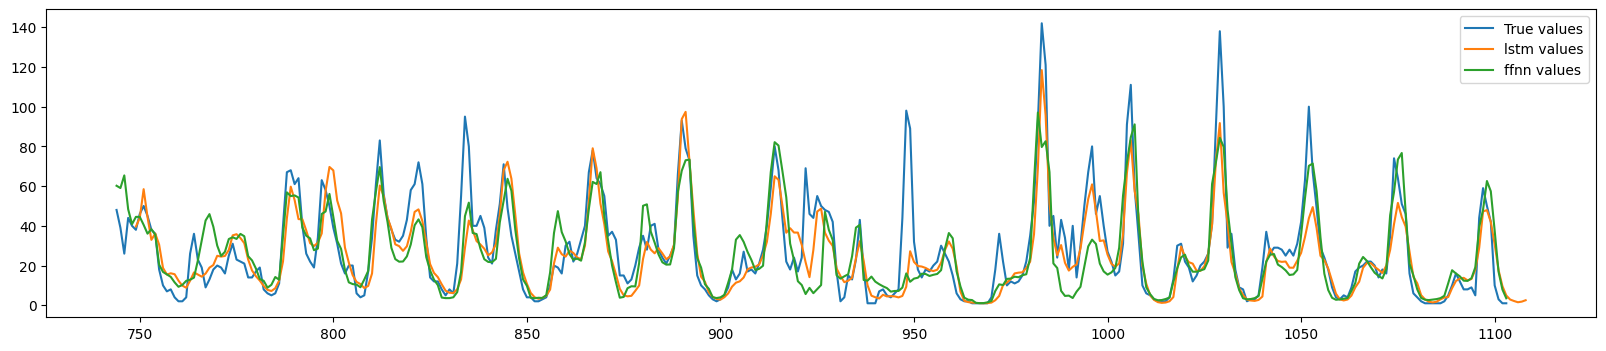

root_mean_squared_error:
 - LSTM: 12.913079940672672
 - FFNN: 15.309223833152833
r2_score:
 - LSTM: 0.6920436581439495
 - FFNN: 0.5676927049875149
mean_absolute_error:
 - LSTM: 6.428883090441418
 - FFNN: 7.685955406784184


In [78]:
samples = 24 * 15
offset = 24 * 31 * 1

plt.figure(figsize=(20,4))
plt.plot(co_y_train.iloc[offset:samples+offset], label='True values')
plt.plot(co_y_pred_df_lstm_train.iloc[offset:samples+offset], label='lstm values')
plt.plot(co_y_pred_df_ffnn_train.iloc[offset:samples+offset], label='ffnn values')
plt.legend()
plt.show()

for m in metrics:
    score_lstm = m(co_y_train.iloc[time_steps:],co_y_pred_df_lstm_train)
    score_ffnn = m(co_y_train,co_y_pred_df_ffnn_train)
    print(f'{m.__name__}:\n - LSTM: {score_lstm}\n - FFNN: {score_ffnn}')